# Historical Optimization on SNMM Initialization Parameters

The first portion of this notebook will focus on reading in, standardizing, and visualizing historical orderbook and trading information. Readers are advised to skip over it and read forward to the interesting parts until they become inspired enough to run this themselves and wonder how it was done.

Getting this historical data was not easy. We use an open-source market data platform to read orderbook deltas as they occur and write them to an RDS instance so we can use them later. As historical data is scarce, these optimizations will by no means be run on an exhaustive quantity of historical data. Improvements need to be made to increase condfidence in this notebook's findings.

In [1]:
# imports
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
from orderbook import Orderbook

## 1. Getting Historical Orderbook Data

Note: Kalshi does not provide historical orderbook data. We have used the open-source Rust Kalshi MDP to collect our own orderbook deltas for the tickers we wish to run historical optimization on.

Code for the MDP can be found [here]('https://github.com/rothcharlie1/kalshi-mdp').

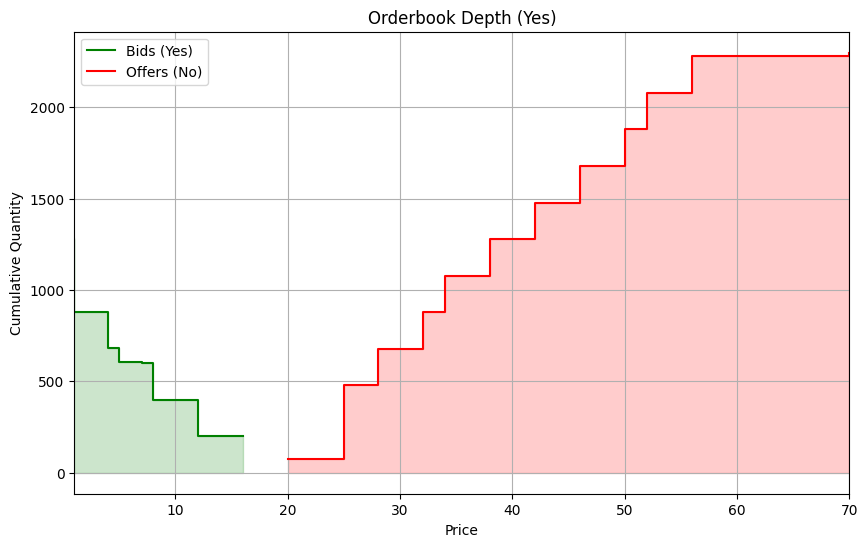

In [7]:
INXD_FILE = 'data/INXD-23DEC21-B4762_orderbooks.json'
orderbook_jsons = []

with open(INXD_FILE) as f:
    for line in f:
        orderbook_jsons.append(line)

orderbooks = [Orderbook.from_json(jsn) for jsn in orderbook_jsons]
orderbooks[100].plot_depth_chart()

In [8]:
# Plot BBO over time
times = [x.ts for x in orderbooks]
times = [pd.Timestamp(x) for x in times]
best_bids = [x.best_bid() for x in orderbooks]
best_offers = [x.best_offer() for x in orderbooks]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times, y=best_bids, mode='lines', name='best bid'))
fig.add_trace(go.Scatter(x=times, y=best_offers, mode='lines', name='best offer'))
fig.update_layout(title='Best Bid and Best Offer over time')
fig.show()

2. Getting Matching Historical Trade Data

Similarly, kalshi does not provide good historical trades data. There is a publicly accessible (hidden, in my opinion) s3 endpoint but those trades don't include the taker-side which prevents us from easily being able to discern whether the trade was a buy or a sell.

In [9]:
INXD_TRADES = 'data/23DEC21-tradeslog.txt'

In [11]:
import re

def extract_trades_from_log(log_contents):
    trades = []
    trade_pattern = re.compile(r'Trade \{ market_ticker: "(.*?)", ts: Some\((\d+)\), yes_price: (\d+), no_price: (\d+), count: (\d+), taker_side: (YES|NO) \}')

    for line in log_contents:
        match = trade_pattern.search(line)
        if match:
            trade = {
                'market_ticker': match.group(1),
                'ts': int(match.group(2)),
                'yes_price': int(match.group(3)),
                'no_price': int(match.group(4)),
                'count': int(match.group(5)),
                'taker_side': match.group(6)
            }
            trades.append(trade)

    return trades

# Extracting trades from the log file
trades_log = open(INXD_TRADES).readlines()
trades = extract_trades_from_log(trades_log)

# Get all trades where the market_ticker is INXD-23DEC21-B4762
inxd_trades = [x for x in trades if x['market_ticker'] == 'INXD-23DEC21-B4762']
len(inxd_trades)

317

In [12]:
# Now plot the BBO over time and place an X on the chart where a trade occurs

# Plot BBO over time
times = [x.ts for x in orderbooks]
times = [pd.Timestamp(x) for x in times]
best_bids = [x.best_bid() for x in orderbooks]
best_offers = [x.best_offer() for x in orderbooks]

fig = go.Figure()
fig.add_trace(go.Scatter(x=times, y=best_bids, mode='lines', name='best bid'))
fig.add_trace(go.Scatter(x=times, y=best_offers, mode='lines', name='best offer'))
fig.update_layout(title='Best Bid and Best Offer over time')

# Add trades to the plot
trade_times = [pd.Timestamp(x['ts']) for x in inxd_trades]
trade_prices = [x['yes_price'] for x in inxd_trades]
fig.add_trace(go.Scatter(x=trade_times, y=trade_prices, mode='markers', name='trades'))

fig.show()